In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve,plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import gc
gc.enable()

In [29]:
data=pd.read_csv('/mnt/d/Churn_Modelling.csv')

In [30]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [31]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [32]:
# check for missing values
data.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [33]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Make figures inline
%matplotlib inline

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


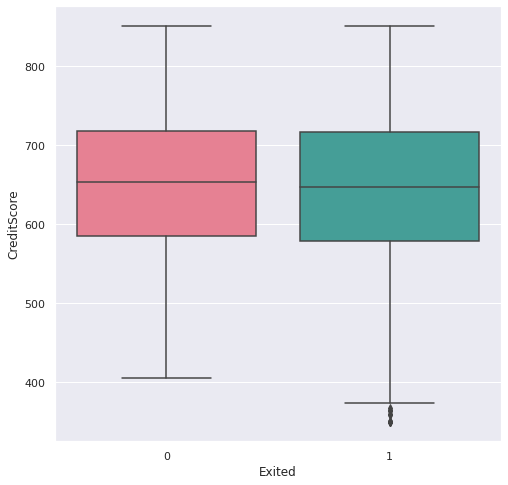

In [35]:
plt.figure(figsize=(8, 8))
sns.set()
sns.boxplot(y = 'CreditScore', x = 'Exited', data = data, palette = 'husl');

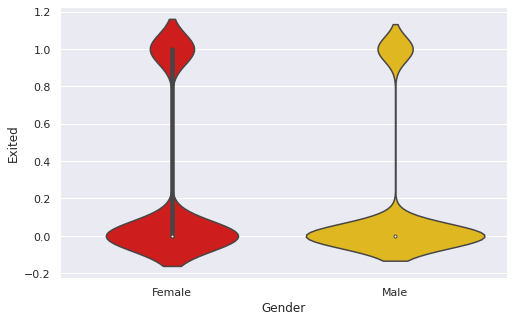

In [36]:
plt.figure(figsize=(8, 5))
sns.violinplot(y = 'Exited' , x = 'Gender' , data = data, kind='boxen', palette = 'hot');

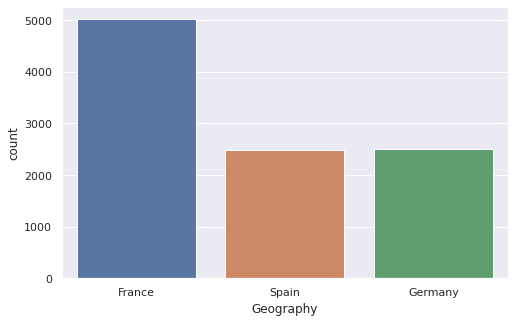

In [37]:
plt.figure(figsize=(8, 5))
sns.countplot(x = 'Geography' , data = data);

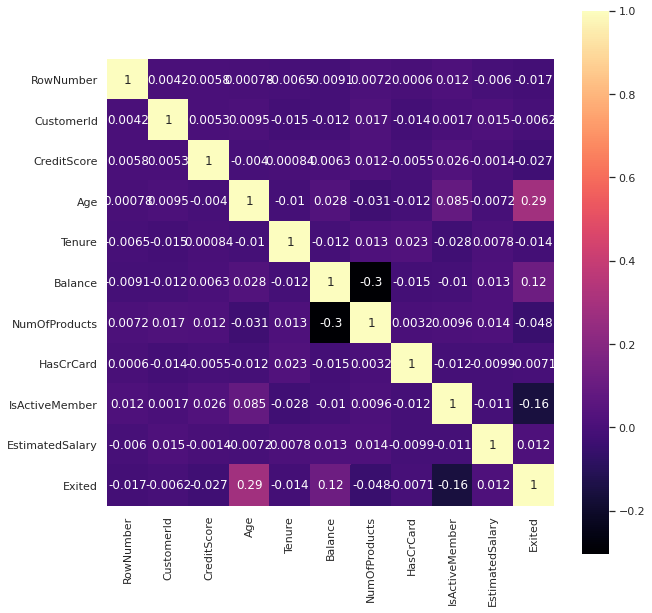

In [38]:
plt.figure(figsize=(10, 10))
sns.set(style = 'white')
sns.heatmap(data.select_dtypes(include='number').corr(), annot = True, cmap = 'magma', square = True);

<Figure size 864x576 with 0 Axes>

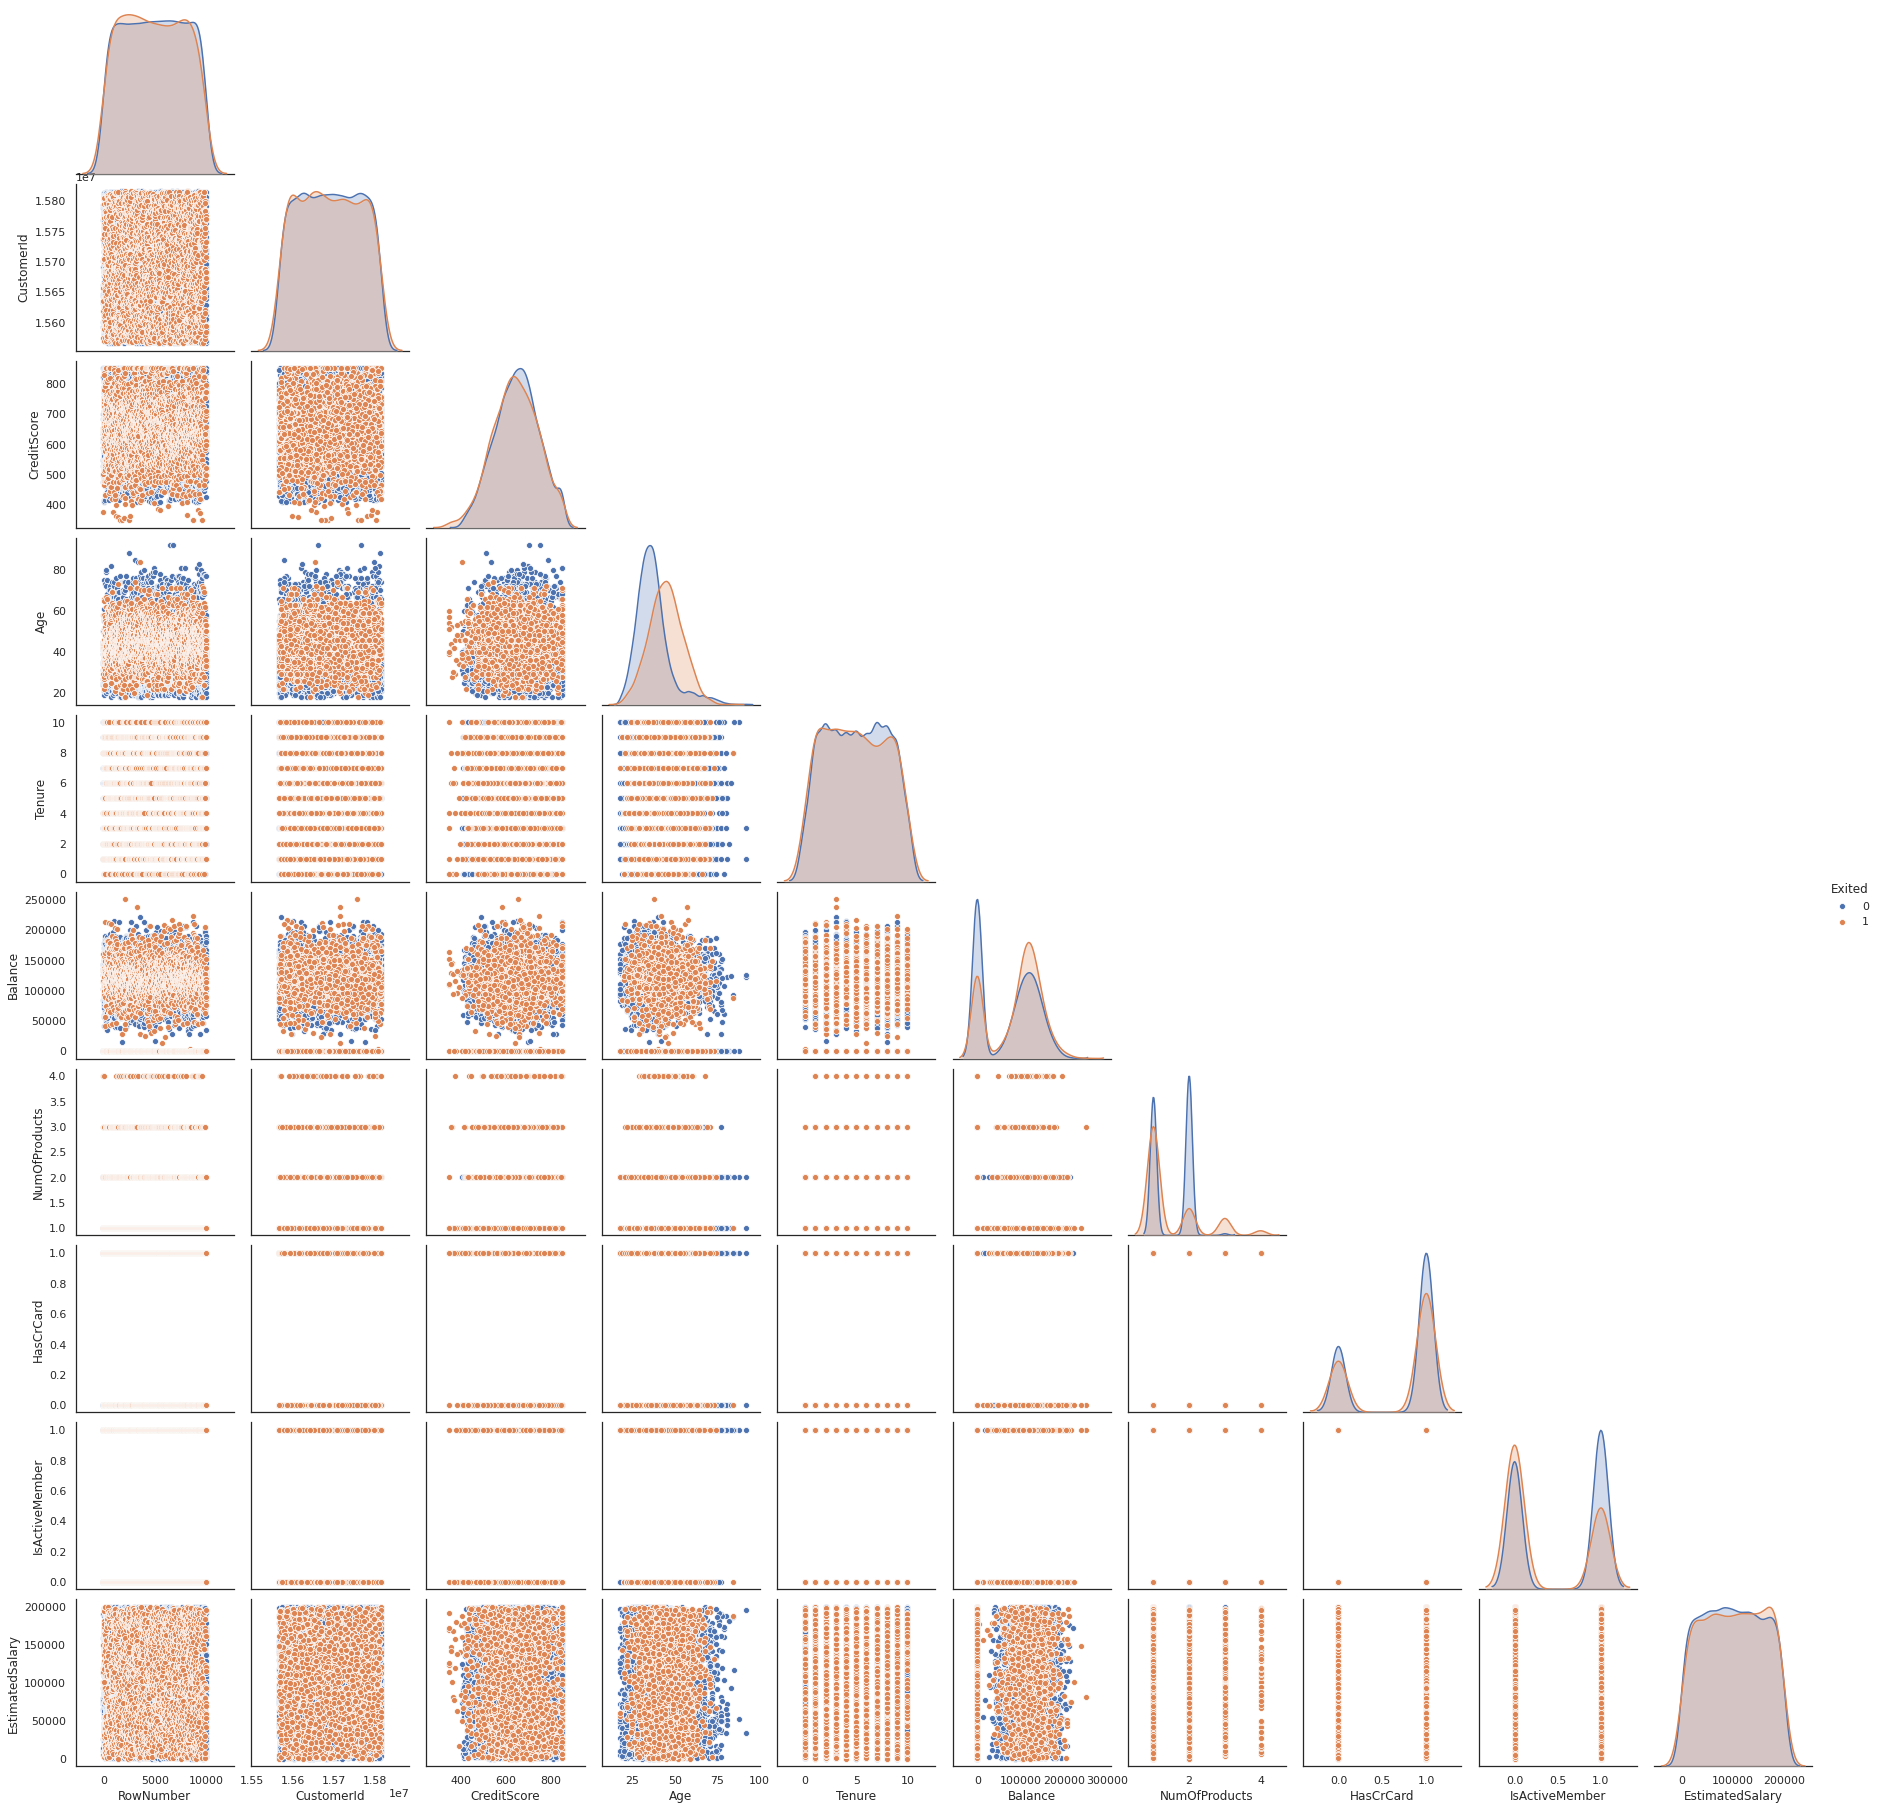

In [39]:
# Pairplot
plt.figure(figsize=(12, 8))
sns.pairplot(data = data, corner = True, hue = 'Exited');

In [40]:
# Drop a useless feature
data.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

In [41]:
# Get dependent and independent features
X = data.iloc[:, :-1]
y = data.iloc[:, -1].astype('float')
X.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,619,France,Female,42,2,0.00,1,1,1,101348.88
1,2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,3,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,4,699,France,Female,39,1,0.00,2,0,0,93826.63
4,5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [42]:
# Splitting to train test dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 1)
len(y_train), len(y_val)

(7500, 2500)

In [43]:
# Reset the indexes of the splitted data frames
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [44]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtypes == object]

In [45]:
# Label encoder object
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Create two empty data frames
X_train_categorical, X_val_categorical = pd.DataFrame(), pd.DataFrame()

# Label Encode the features
for col in categorical_cols:
    X_train_categorical[col] = label_encoder.fit_transform(X_train[col])
    X_val_categorical[col] = label_encoder.transform(X_val[col])

# Drop the non required columns
X_train.drop(categorical_cols, axis = 1, inplace = True)
X_val.drop(categorical_cols, axis = 1, inplace=True)

# put new colums in dataframe
X_train = X_train.join(X_train_categorical)
X_val = X_val.join(X_val_categorical)

/home/munna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
from imblearn.over_sampling import SMOTE
smk = SMOTE()
# Oversample training  data
X_train, y_train = smk.fit_sample(X_train, y_train)

# Oversample validation data
X_val, y_val = smk.fit_sample(X_val, y_val)

In [24]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [25]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy (train) for smote- decision tree: 77.2% 


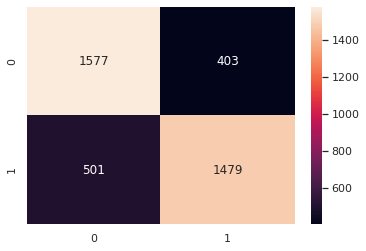

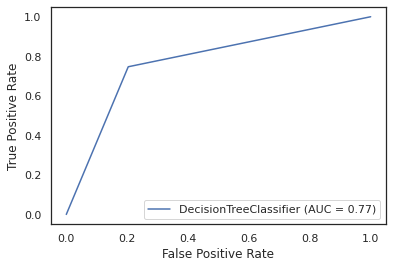

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
import seaborn as sns

y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
name = 'smote- decision tree'
print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
cm2 = confusion_matrix(y_val, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

svc_disp = plot_roc_curve(clf, X_val, y_val)

In [46]:
from imblearn.over_sampling import ADASYN
smk = ADASYN()
# Oversample training  data
X_train, y_train = smk.fit_sample(X_train, y_train)

# Oversample validation data
X_val, y_val = smk.fit_sample(X_val, y_val)

In [47]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [48]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy (train) for smote- decision tree: 75.3% 


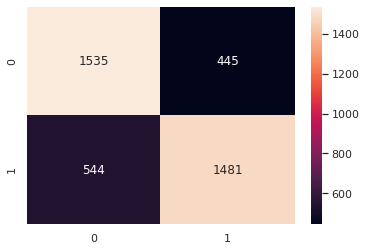

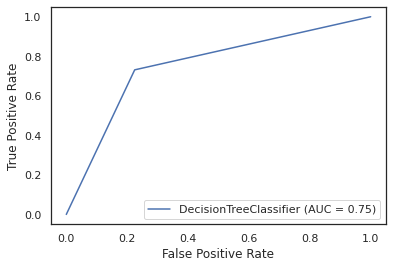

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
import seaborn as sns

y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
name = 'smote- decision tree'
print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
cm2 = confusion_matrix(y_val, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

svc_disp = plot_roc_curve(clf, X_val, y_val)